# Titanic: Machine Learning from Disaster

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

This notebook  build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

## 1. Problem Definition

In our case, the problem will be exploring is classification. We should predict whether or not passenger survive.

## 2. Data

The data we're using is from Kaggle : https://www.kaggle.com/c/titanic/data

The data has been split into two groups:

* training set (train.csv)
* test set (test.csv)

## 3. Evaluation

Since machine learning is very experimental, you might say something like,

> If we can reach about 75% accuracy at predicting whether or not passenger survive, we'll pursure this project.

## 4. Features

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

***Variable Notes***

* pclass: A proxy for socio-economic status (SES)
    * 1st = Upper
    * 2nd = Middle
    * 3rd = Lower

* age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

* sibsp: The dataset defines family relations in this way...
    * Sibling = brother, sister, stepbrother, stepsister
    * Spouse = husband, wife (mistresses and fiancés were ignored)

* parch: The dataset defines family relations in this way...
    * Parent = mother, father
    * Child = daughter, son, stepdaughter, stepson
    * Some children travelled only with a nanny, therefore parch=0 for them.

## Preparing the tools
* pandas for data analysis
* NumPy for numerical operations
* Matplotlib/seaborn for plotting of data visualization
* Scikit-Learn for machine learning modelling and evaluation

In [1]:
# Regular EDA and plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Parsing Data
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Model evaluators
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_roc_curve

### Data Analysis

Let's load `train.csv` and `test.csv` as a DataFrame and get some information about data.

**Note:**

For prediction we need test data in the same format as a train data, so if we change something in train data, we'll do the same in test data.

In [51]:
# load train data as data frame
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
res_df = test_df[['PassengerId', 'Name']]
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# check info about train data, like nums of missing values and type of values
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


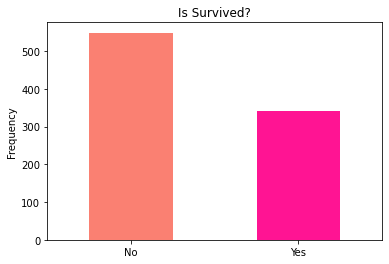

In [4]:
# plot how many passangers survived and not
df = train_df['Survived'].value_counts()
df.index = ['No', 'Yes']
df.plot(kind='bar', color=['salmon', 'deeppink'])
plt.title('Is Survived?')
plt.ylabel('Frequency')
plt.xticks(rotation='horizontal');

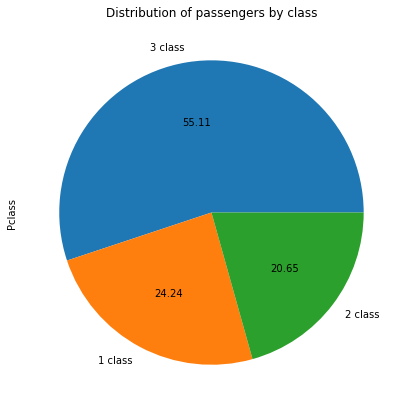

In [5]:
# plot how many passangers in each class
plt.figure(figsize=(9, 7))
train_df['Pclass'].value_counts().plot(kind='pie', subplots=True, labels=['3 class', '1 class', '2 class'], autopct='%.2f');
plt.title('Distribution of passengers by class');

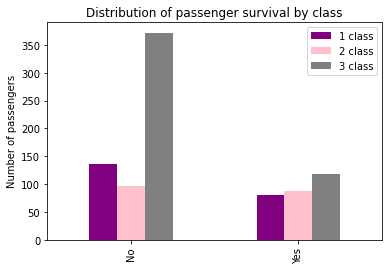

In [6]:
# plot how many passangers survived and not by class
dict_survived_per_class = {}
for i in range(1, 4):
    tmp = train_df[train_df['Pclass'] == i][['Pclass', 'Survived']].value_counts()
    not_survived = tmp.iloc[0]
    survived = tmp.iloc[1]
    dict_survived_per_class[str(i) + ' class'] = [not_survived, survived]
df_survived_per_class = pd.DataFrame(dict_survived_per_class, index=['No', 'Yes'])
df_survived_per_class.plot(kind='bar', color=['purple', 'pink', 'gray']);
plt.title("Distribution of passenger survival by class");
plt.ylabel("Number of passengers");

### Correlation between independent variables

We can do this using df.corr() which will create a correlation matrix for us, in other words, a big table of numbers telling us how related each variable is the other.

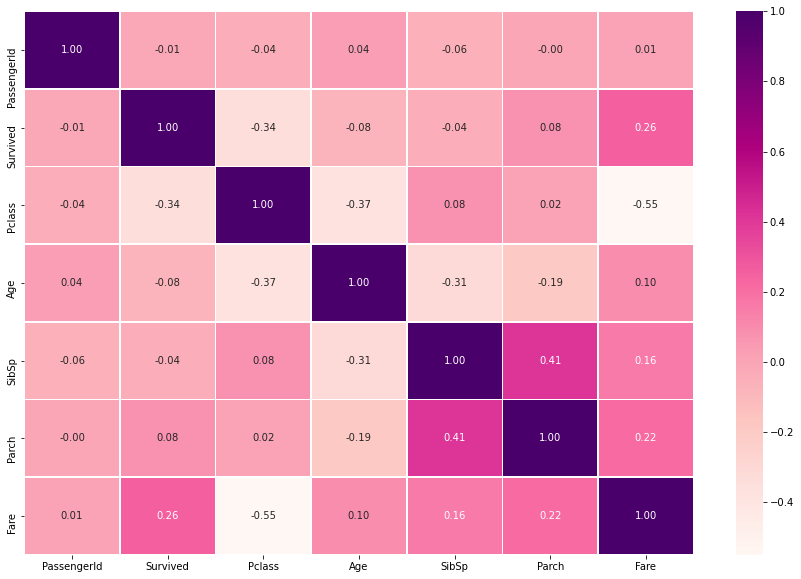

In [7]:
corr_matrix = train_df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="RdPu");

### Parsing data

To make predictions on train data, we need to be sure, that:
* data doesn't contain `NaN` values
* all data in a numerical format

Check, that our target column doesn't contains `NaN` values, otherwise drop them.

In [8]:
if train_df['Survived'].isna().sum():
    train_df = train_df.dropna(subset=["Survived"])
    
print(f"Number of missing values in target column \'Survived\' equals {train_df['Survived'].isna().sum()}")

Number of missing values in target column 'Survived' equals 0


Because we have PassengerId we don't need a full name of passenger, so let's drop it.

In [9]:
train_df.drop('Name', axis=1, inplace=True)
test_df.drop('Name', axis=1, inplace=True)
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S


Let's look which types of columns we have.

In [10]:
train_df.shape, test_df.shape

((891, 11), (418, 10))

In [11]:
# check data types for train
print("TRAIN DATA")
for label, values in train_df.items():
    print(label, " type is" , values.dtype)
    
# check data types for test
print("\nTEST DATA")
for label, values in test_df.items():
    print(label, " type is" , values.dtype)

TRAIN DATA
PassengerId  type is int64
Survived  type is int64
Pclass  type is int64
Sex  type is object
Age  type is float64
SibSp  type is int64
Parch  type is int64
Ticket  type is object
Fare  type is float64
Cabin  type is object
Embarked  type is object

TEST DATA
PassengerId  type is int64
Pclass  type is int64
Sex  type is object
Age  type is float64
SibSp  type is int64
Parch  type is int64
Ticket  type is object
Fare  type is float64
Cabin  type is object
Embarked  type is object


In [12]:
# check NaN values for train
print("TRAIN DATA")
print(train_df.isna().sum())

# check NaN values for test
print("\nTEST DATA")
print(test_df.isna().sum())

TRAIN DATA
PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

TEST DATA
PassengerId      0
Pclass           0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


So, we need to convert object data into numerical and fill missing values. For example, convert column `Sex`
 * female -> 1
 * male -> 0

In [13]:
# create simple function to convert "Sex" column
def convert_sex_column(df):
    new_sex = []

    for i in train_df['Sex']:
        if i == 'male':
            new_sex.append(0)
        else:
            new_sex.append(1)
    df['Sex'] = pd.Series(new_sex)

# train
convert_sex_column(train_df)

#test
convert_sex_column(test_df)

train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,0,35.0,0,0,373450,8.0500,NaN,S


In [14]:
# check data types
print("TRAIN DATA")
for label, values in train_df.items():
    print(label, " type is" , values.dtype)

TRAIN DATA
PassengerId  type is int64
Survived  type is int64
Pclass  type is int64
Sex  type is int64
Age  type is float64
SibSp  type is int64
Parch  type is int64
Ticket  type is object
Fare  type is float64
Cabin  type is object
Embarked  type is object


Missing values in column `Age` we can fill with the median.

In [15]:
# define features to numerical
numerical_features = ['Age', 'Fare']

# create numeric transformer Pipeline
numeric_transformer = Pipeline(steps=[
    # Set SimpleImputer strategy to fill missing values with the "Median"
    ("imputer", SimpleImputer(strategy="median"))
])

Let's look on columns `Cabin` and `Embarked`. They are in object format and both have missing values. So, we'll create our preprocessing Pipeline which fills missing values along with turning all non-numerical data into numbers.

Column `Ticket` also has an object type, but hasn't missing values. We need only turn all non-numerical data into numbers.

In [16]:
# define categorical features
categorical_features = ['Cabin', 'Embarked', 'Ticket']

# create categorical transformer Pipeline
categorical_transformer = Pipeline(steps=[
    # Set SimpleImputer strategy to "constant" and fill value to "missing"
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    # Set OneHotEncoder to ignore the unknowns
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

Time to put all of our individual transformer Pipeline's into a single ColumnTransformer instance.

In [17]:
# Setup preprocessing steps (fill missing values, then convert to numbers)
preprocessor = ColumnTransformer(
    transformers=[
        # Use the categorical_transformer to transform the categorical_features
        ("cabin_emberked_ticket", categorical_transformer, categorical_features),
        # Use the numeric_transformer to transform the numeric_features
        ("age", numeric_transformer, numerical_features)])

Now our preprocessor is ready, time to import some classification models to try out.

### Modeling

We'll be using the following models and comparing their results.

* LogisticRegression
* KNeighborsClassifier
* RandomForestClassifier

In [18]:
# put models into a dictionary
classification_models = {"LogisticRegression" : LogisticRegression(max_iter=500),
          "KNeighborsClassifier" : KNeighborsClassifier(),
          "RandomForestClassifier" : RandomForestClassifier()}

# create an empty dictionary for the classification results
classification_results = {}

Split data on X & y variables. 
* X - data for training and testing (without "Survived")
* y - column to predict (Survived)

Also we create a validation dataset, to score our results.

In [19]:
# everything except target variable
X = train_df.drop(["Survived"], axis=1)
X_test = test_df
# target variable
y = train_df["Survived"]

# train and validation (20% from X) data sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the training and test datasets
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((712, 10), (179, 10), (712,), (179,))

Let's build a small loop which is going to:

* Go through our `classification_models` dictionary
* Create a Pipeline which contains our `preprocessor` as well as one of the models in the dictionary
* Fits the Pipeline to the training data

In [20]:
# Loop through the items in the classification_models dictionary
for model_name, model in classification_models.items():
    
    # Create a model pipeline with a preprocessor step and model step
    model_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                      ("model", model)])
    
    # Fit the model pipeline to the training data
    print(f"\nFitting {model_name}...")
    model_pipeline.fit(X_train, y_train)
    print(f"{model_name} was fitted!")
    
    # Score the model pipeline on the validation data appending the model_name to the 
    # results dictionary
    print(f"Scoring {model_name}...")
    classification_results[model_name] = round(model_pipeline.score(X_val, y_val) * 100, 2)
    print(f"{model_name} was scored!")


Fitting LogisticRegression...
LogisticRegression was fitted!
Scoring LogisticRegression...
LogisticRegression was scored!

Fitting KNeighborsClassifier...
KNeighborsClassifier was fitted!
Scoring KNeighborsClassifier...
KNeighborsClassifier was scored!

Fitting RandomForestClassifier...
RandomForestClassifier was fitted!
Scoring RandomForestClassifier...
RandomForestClassifier was scored!


{'LogisticRegression': 75.98, 'KNeighborsClassifier': 66.48, 'RandomForestClassifier': 70.39}


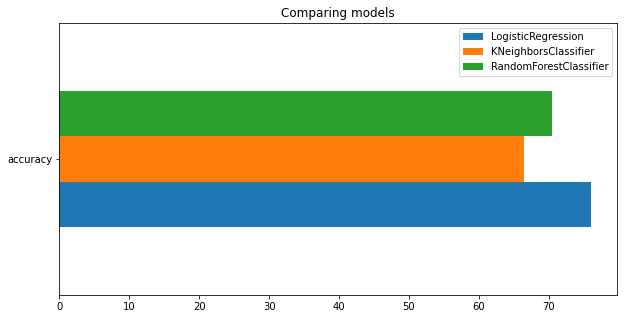

In [21]:
# Check the results of each classification model by printing the classification_results dictionary
print(classification_results)
pd.DataFrame(classification_results, index=["accuracy"]).plot(kind='barh', figsize=(10, 5),
                                                              title="Comparing models");

## Tuning models

Let's tune our models, using GridSearchCV. So, we need pick parameters grid for each model.

In [22]:
# different models hyperparameters
param_grid = {"LogisticRegression" : {'logisticregression__penalty' : ['l2', 'elasticnet'], 
                                      'logisticregression__C': np.logspace(-4, 4, 20), 
                                      'logisticregression__solver' : ["liblinear", "saga", "newton-cg"]},
          "KNeighborsClassifier" : {'kneighborsclassifier__n_neighbors' : np.arange(1,30), 
                                    'kneighborsclassifier__weights' : ["uniform", "distance"], 
                                    'kneighborsclassifier__metric' : ['minkowski','euclidean','manhattan']},
          "RandomForestClassifier" : {'randomforestclassifier__n_estimators' : np.arange(10, 1010, 100),  
                                      'randomforestclassifier__max_depth' : [1, 5, 10, 25, 50, 75, 100], 
                                      'randomforestclassifier__max_features' : np.arange(0.1, 1.1, 0.1), 
                                      'randomforestclassifier__min_samples_leaf' : [1, 2, 4],
                                      'randomforestclassifier__min_samples_split' : [2, 5, 10]}}
              

# create an empty dictionary for the models best parameters
best_parameters_by_model = {}

# create an empty dictionary for the classification results
classification_results_tune = {}

# create an empty dictionary for the val models predictions
y_val_preds = {}

# create an empty dictionary for the models predictions
y_preds = {}

In [23]:
# Loop through the items in the classification_models dictionary
for model_name, model in classification_models.items():
    
    # Create a model pipeline with a preprocessor step and model step    
    model_pipeline = make_pipeline(preprocessor, model)
    
    # setup grid hyperparameter search for LogisticRegression
    model_pipeline_tune = GridSearchCV(model_pipeline,
                          param_grid=param_grid[model_name],
                          cv=5,
                          verbose=True, 
                         n_jobs=-1)
    
    # Fit the model pipeline to the training data
    print(f"\nFitting {model_name}...")
    model_pipeline_tune.fit(X_train, y_train)
    print(f"{model_name} was fitted!")
    
    # fill the best barameters finding by GridSearchCV for each model
    best_parameters_by_model[model_name] = model_pipeline_tune.best_params_
    
    # Score the model pipeline on the validation data appending the model_name to the 
    # results dictionary
    print(f"Scoring {model_name}...")
    classification_results_tune[model_name] = round(model_pipeline_tune.score(X_val, y_val) * 100, 2)
    print(f"{model_name} was scored!")
    
    # predictions on validation data
    y_val_preds[model_name] = model_pipeline_tune.predict(X_val)

    # predictions on test data
    print(f"Making predictions {model_name}...")
    y_preds[model_name] = model_pipeline_tune.predict(X_test)
    print(f"{model_name} predictions done!")


Fitting LogisticRegression...
Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 569 out of 600 | elapsed:    4.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


LogisticRegression was fitted!
Scoring LogisticRegression...
LogisticRegression was scored!
Making predictions LogisticRegression...
LogisticRegression predictions done!

Fitting KNeighborsClassifier...
Fitting 5 folds for each of 174 candidates, totalling 870 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 870 out of 870 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


KNeighborsClassifier was fitted!
Scoring KNeighborsClassifier...
KNeighborsClassifier was scored!
Making predictions KNeighborsClassifier...
KNeighborsClassifier predictions done!

Fitting RandomForestClassifier...
Fitting 5 folds for each of 6300 candidates, totalling 31500 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 466 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 1266 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1816 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2466 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3216 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 4066 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 5016 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 6066 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 7216 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 8466 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 9816 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 11266 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 12816 tasks      | elapsed: 18

RandomForestClassifier was fitted!
Scoring RandomForestClassifier...
RandomForestClassifier was scored!
Making predictions RandomForestClassifier...
RandomForestClassifier predictions done!


In [24]:
# check best parameters
best_parameters_by_model

{'LogisticRegression': {'logisticregression__C': 1.623776739188721,
  'logisticregression__penalty': 'l2',
  'logisticregression__solver': 'newton-cg'},
 'KNeighborsClassifier': {'kneighborsclassifier__metric': 'manhattan',
  'kneighborsclassifier__n_neighbors': 17,
  'kneighborsclassifier__weights': 'uniform'},
 'RandomForestClassifier': {'randomforestclassifier__max_depth': 25,
  'randomforestclassifier__max_features': 0.2,
  'randomforestclassifier__min_samples_leaf': 2,
  'randomforestclassifier__min_samples_split': 5,
  'randomforestclassifier__n_estimators': 810}}

In [25]:
# Check the results of each classification model by printing the classification_results dictionary
print("WITHOUT TUNE")
print(classification_results)
print("WITH TUNE")
print(classification_results_tune)

WITHOUT TUNE
{'LogisticRegression': 75.98, 'KNeighborsClassifier': 66.48, 'RandomForestClassifier': 70.39}
WITH TUNE
{'LogisticRegression': 76.54, 'KNeighborsClassifier': 70.95, 'RandomForestClassifier': 73.74}


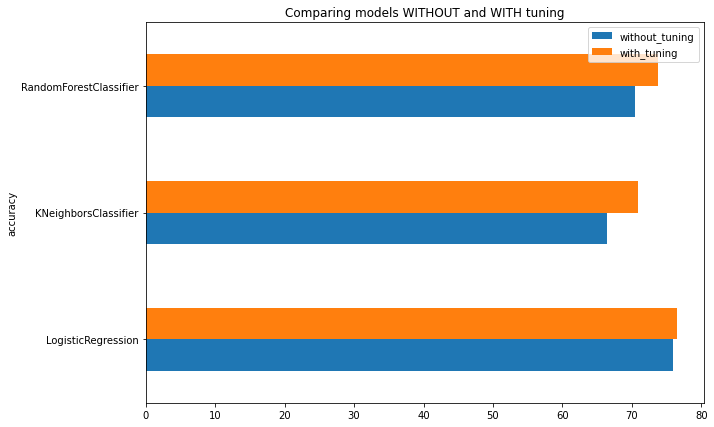

In [26]:
compare_metrics = pd.DataFrame({"without_tuning": classification_results,
                                "with_tuning": classification_results_tune})
compare_metrics.plot.barh(figsize=(10, 7), ylabel="accuracy", title="Comparing models WITHOUT and WITH tuning");

### Evaluating a classification model, beyond accuracy

We want:

* Confusion matrix - confusion_matrix()
* Classification report - classification_report()

**Confusion matrix**

A confusion matrix is a visual way to show where your model made the right predictions and where it made the wrong predictions (or in other words, got confused).

Scikit-Learn allows us to create a confusion matrix using confusion_matrix() and passing it the true labels and predicted labels.

3


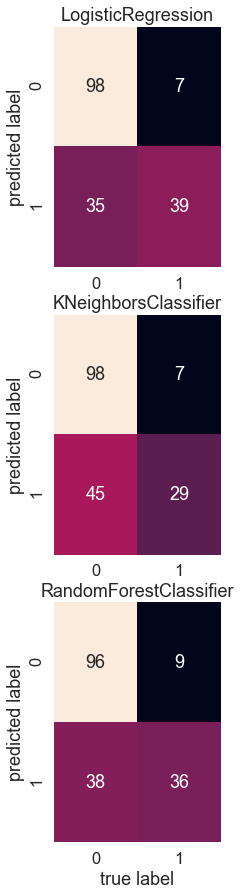

In [27]:
sns.set(font_scale=1.5) # Increase font size

def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    plt.figure(figsize=(3, 15))
    i = 1
    for model_name, predictions_by_model in y_preds.items():
        ax = plt.subplot(3, 1, i)
        ax = sns.heatmap(confusion_matrix(y_test, predictions_by_model),
                     annot=True, # Annotate the boxes
                     cbar=False)
        plt.ylabel("predicted label")
        plt.title(model_name)
        i += 1
    plt.xlabel("true label")

print(len(y_val_preds))
plot_conf_mat(y_val, y_val_preds)

**Classification report**

We can make a classification report using classification_report() and passing it the true labels as well as our models predicted labels.

A classification report will also give us information of the precision and recall of our model for each class.

In [28]:
# show classification report
for model_name, prediction_by_model in y_val_preds.items():
    print('\t' + model_name)
    print(classification_report(y_val, prediction_by_model))


	LogisticRegression
              precision    recall  f1-score   support

           0       0.74      0.93      0.82       105
           1       0.85      0.53      0.65        74

    accuracy                           0.77       179
   macro avg       0.79      0.73      0.74       179
weighted avg       0.78      0.77      0.75       179

	KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.69      0.93      0.79       105
           1       0.81      0.39      0.53        74

    accuracy                           0.71       179
   macro avg       0.75      0.66      0.66       179
weighted avg       0.74      0.71      0.68       179

	RandomForestClassifier
              precision    recall  f1-score   support

           0       0.72      0.91      0.80       105
           1       0.80      0.49      0.61        74

    accuracy                           0.74       179
   macro avg       0.76      0.70      0.70       179
weighted

### Result



In [52]:
# create simple function to convert row from 0 and 1 to 'No' and 'Yes'
def convert_predictions(y_pred):
    new_preds = []
    for pred in y_pred:
        if pred == 0:
            new_preds.append('No')
        else:
            new_preds.append('Yes')
    return new_preds

In [53]:
new_preds = {}
for model_name, prediction_by_model in y_preds.items():
    new_preds[model_name] = convert_predictions(prediction_by_model)

In [54]:
log_reg_df = res_df.copy()
log_reg_df['Survived'] = new_preds['LogisticRegression']
log_reg_df.head()

,PassengerId,Name,Survived
0,892,"Kelly, Mr. James",No
1,893,"Wilkes, Mrs. James (Ellen Needs)",No
2,894,"Myles, Mr. Thomas Francis",No
3,895,"Wirz, Mr. Albert",No
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",No


In [55]:
knn_df = res_df.copy()
knn_df['Survived'] = new_preds['KNeighborsClassifier']
knn_df.head()

,PassengerId,Name,Survived
0,892,"Kelly, Mr. James",No
1,893,"Wilkes, Mrs. James (Ellen Needs)",No
2,894,"Myles, Mr. Thomas Francis",No
3,895,"Wirz, Mr. Albert",No
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",No


In [56]:
ran_for_df = res_df.copy()
ran_for_df['Survived'] = new_preds['RandomForestClassifier']
ran_for_df.head()

,PassengerId,Name,Survived
0,892,"Kelly, Mr. James",No
1,893,"Wilkes, Mrs. James (Ellen Needs)",No
2,894,"Myles, Mr. Thomas Francis",No
3,895,"Wirz, Mr. Albert",No
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",No
